In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, get_scorer_names
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from xgboost import plot_importance

import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-2-c2555a6b2d8b>:5: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,S,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def Split_train_test(drug):
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  Drug_df = pd.concat(df_list, axis=1)

  Drug_df = Drug_df.dropna()

  Train_test_dic = {}

  labels = Drug_df[drug]

  features = Drug_df.drop(columns=[drug])

  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [4]:
AMP_Train_test_dic = Split_train_test("AMP")

print("AMP")
for k, df in AMP_Train_test_dic.items():
  print(k, df.shape)
  if k.startswith("labels"):
    print(df.value_counts())

AMP
labels_train (626,)
AMP
R    473
S    153
Name: count, dtype: int64
features_train (626, 17201)
labels_test (157,)
AMP
R    119
S     38
Name: count, dtype: int64
features_test (157, 17201)


In [5]:
combo_list = ['Y', 'G', 'GY']

def combo_feat(features_df, drug, combo):

  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df = pd.concat(df_list, axis=1)
    Y_feat_df = Y_feat_df.drop(columns=['Isolate'])
    return Y_feat_df

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

In [6]:
AMP_GY_train_df = combo_feat(AMP_Train_test_dic['features_train'],"AMP","GY")

AMP_GY_train_df.columns

Index(['Year', 'MLST', 'yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB',
       'narQ',
       ...
       'group_48768', 'group_48873', 'group_48916', 'group_48933',
       'group_48937', 'group_48958', 'group_49020', 'group_49174',
       'group_49253', 'group_49257'],
      dtype='object', length=17200)

In [7]:
def run_GB(feat_train_df, lab_train, drug, combo):
  labels = lab_train
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_t = le.transform(labels)
  print(drug +" Training combo: "+ combo)
  GB =  XGBClassifier(random_state = 42)
  feat = feat_train_df.drop(columns=["MLST"])
  GB = GB.fit(feat, labels_t)
  print("Number of Decicion Trees in XGB Classifier model:", GB.n_estimators)
  return GB

In [8]:
GB_AMP_GY_model = run_GB(AMP_GY_train_df, AMP_Train_test_dic['labels_train'],"AMP","GY")
GB_AMP_GY_model

AMP Training combo: GY
Number of Decicion Trees in XGB Classifier model: None


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

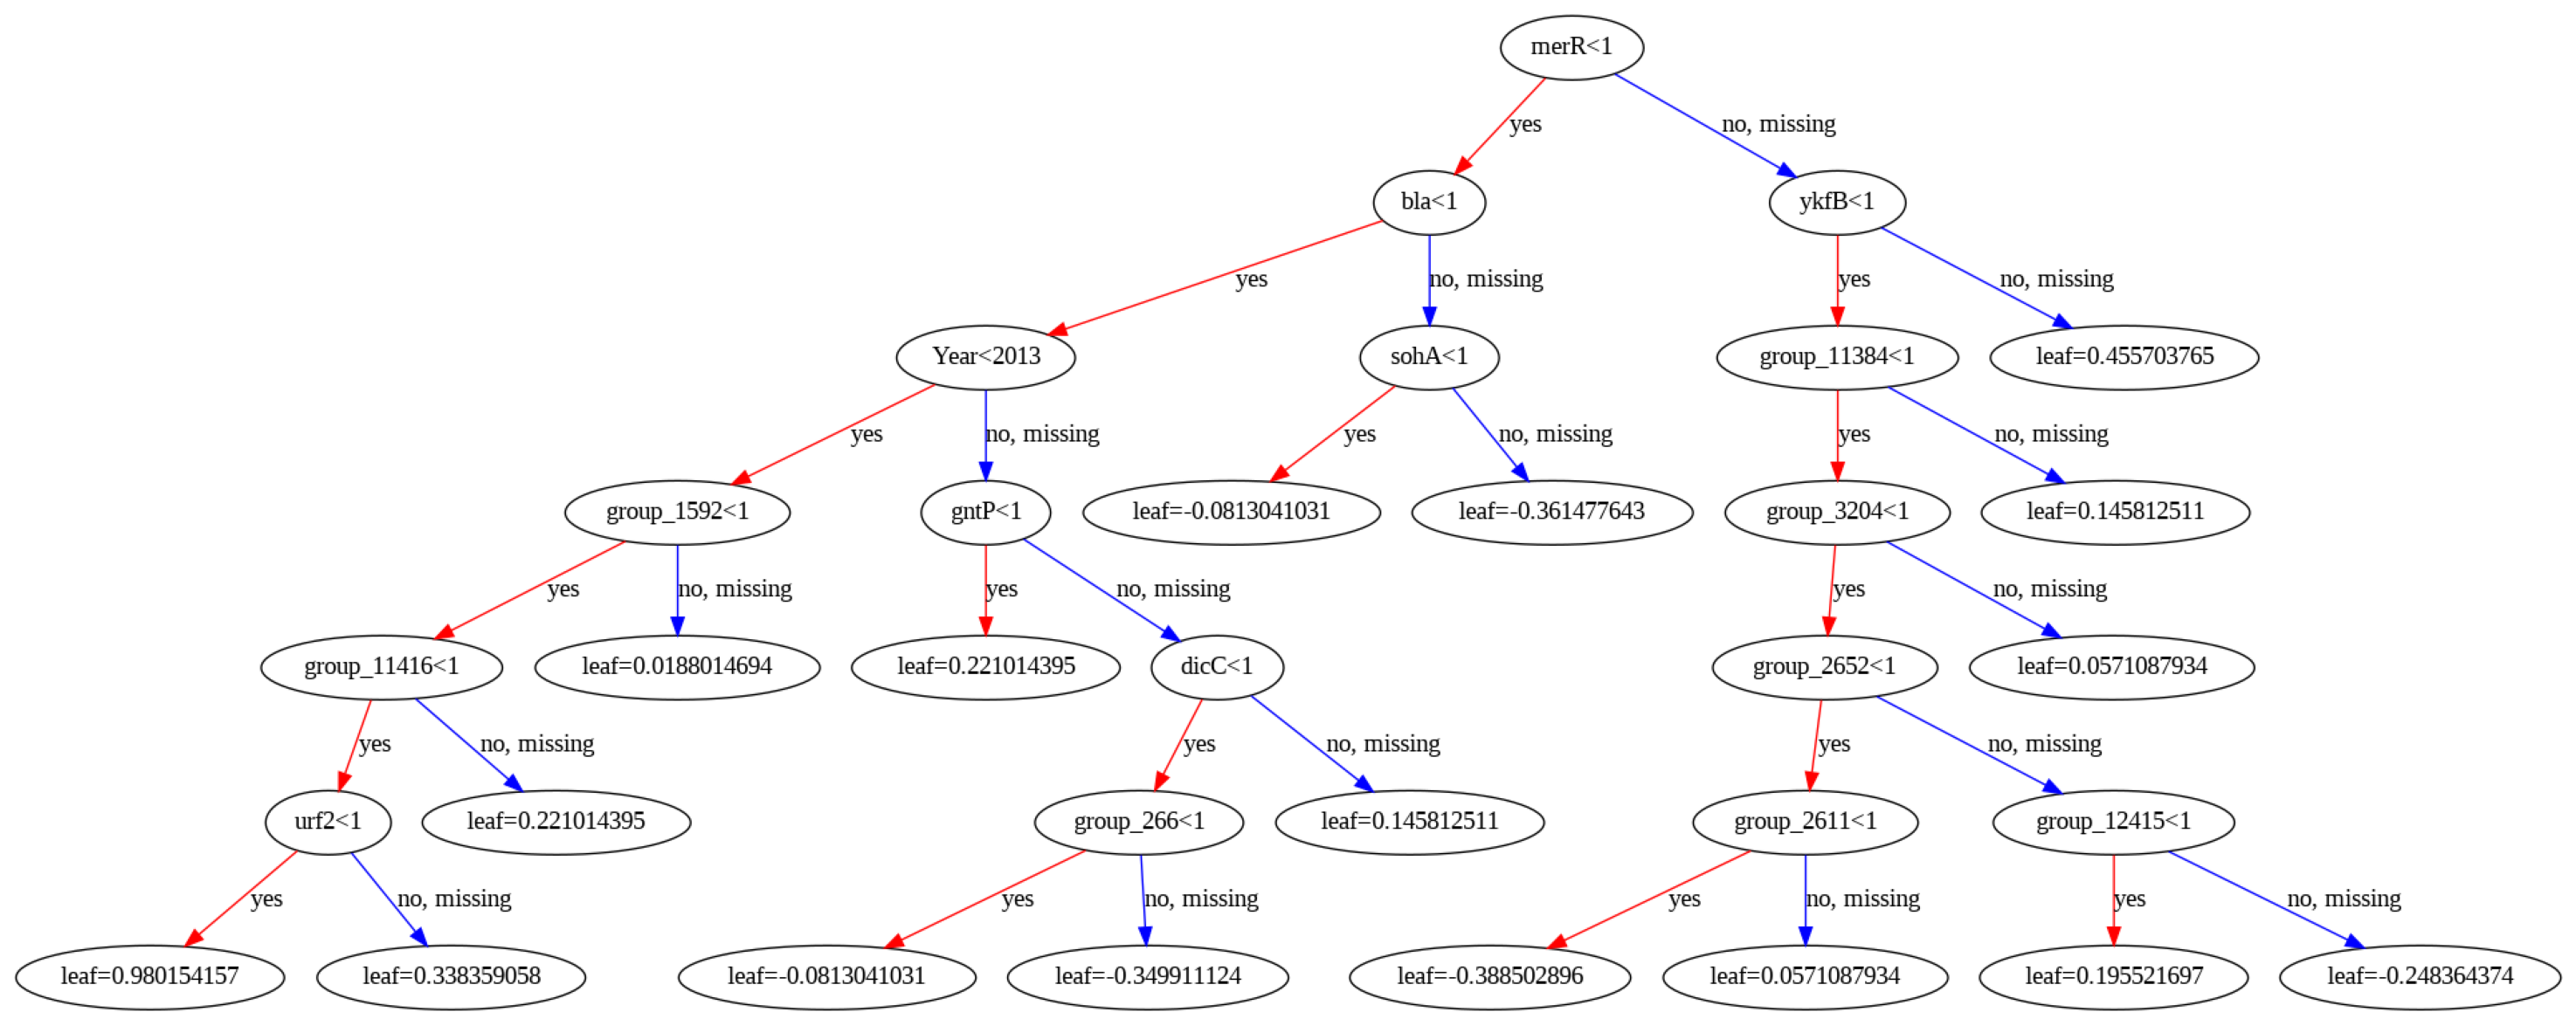

In [9]:
plot_tree(GB_AMP_GY_model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(40, 15)

In [10]:
print(GB_AMP_GY_model.get_booster().get_dump(with_stats = True)[0])

0:[merR<1] yes=1,no=2,missing=2,gain=187.596527,cover=121.801666
	1:[bla<1] yes=3,no=4,missing=4,gain=77.4763184,cover=47.4754066
		3:[Year<2013] yes=7,no=8,missing=8,gain=92.2459869,cover=38.5251274
			7:[group_1592<1] yes=13,no=14,missing=14,gain=11.4184113,cover=28.4074173
				13:[group_11416<1] yes=19,no=20,missing=20,gain=4.83761597,cover=27.0454178
					19:[urf2<1] yes=25,no=26,missing=26,gain=0.843048096,cover=25.4888458
						25:leaf=0.980154157,cover=23.9322758
						26:leaf=0.338359058,cover=1.55657077
					20:leaf=0.221014395,cover=1.55657077
				14:leaf=0.0188014694,cover=1.36199939
			8:[gntP<1] yes=15,no=16,missing=16,gain=4.51236534,cover=10.1177101
				15:leaf=0.221014395,cover=1.55657077
				16:[dicC<1] yes=21,no=22,missing=22,gain=3.87284803,cover=8.56113911
					21:[group_266<1] yes=27,no=28,missing=28,gain=0.30401516,cover=7.1991396
						27:leaf=-0.0813041031,cover=1.16742802
						28:leaf=-0.349911124,cover=6.03171158
					22:leaf=0.145812511,cover=1.36199939
		4:

In [11]:
num_labels = AMP_Train_test_dic['labels_train'].copy()

num_labels.loc[num_labels == "S"] = 1.0
num_labels.loc[num_labels == "R"] = 0.0

feat_df = AMP_GY_train_df.drop(columns=["MLST"])
d = xgb.DMatrix(feat_df, label=num_labels)

p = {'max_depth':6, 'eta':0.33, 'objective':'binary:logistic'}

res = xgb.cv(params = p, dtrain=d, num_boost_round=100, verbose_eval=10, metrics="error")

[0]	train-error:0.07428+0.00708	test-error:0.10706+0.01284
[10]	train-error:0.00799+0.00299	test-error:0.07825+0.01180
[20]	train-error:0.00000+0.00000	test-error:0.07826+0.00971
[30]	train-error:0.00000+0.00000	test-error:0.08145+0.00767
[40]	train-error:0.00000+0.00000	test-error:0.08625+0.01022
[50]	train-error:0.00000+0.00000	test-error:0.08464+0.00968
[60]	train-error:0.00000+0.00000	test-error:0.08464+0.00968
[70]	train-error:0.00000+0.00000	test-error:0.08624+0.01018
[80]	train-error:0.00000+0.00000	test-error:0.08783+0.01178
[90]	train-error:0.00000+0.00000	test-error:0.09104+0.00765
[99]	train-error:0.00000+0.00000	test-error:0.08625+0.00659


In [12]:
def predict(GB_combo_Model, features_test):
  feat = features_test.drop(columns=['MLST'])
  labels_pred = GB_combo_Model.predict(feat)
  if is_numeric_dtype(labels_pred):
    # transforming labels from numbers to letters
    lab_pred_t = labels_pred.astype('O')
    lab_pred_t[lab_pred_t==0] = 'R'
    lab_pred_t[lab_pred_t==1] = 'S'
    return lab_pred_t
  else:
    return labels_pred

In [13]:
AMP_GY_test_df = combo_feat(AMP_Train_test_dic['features_test'],"AMP","GY")

AMP_GY_test_df.shape

(157, 17200)

In [14]:
AMP_GY_labels_pred = predict(GB_AMP_GY_model,AMP_GY_test_df)

print("Labels predicted: ", np.unique(AMP_GY_labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([118,  39]))


In [15]:
def evaluate(GB_combo_model, labels_test, labels_pred, cf= True, show_results=True):
  report = classification_report(labels_test, labels_pred, output_dict = True)
  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=np.where(GB_combo_model.classes_<1,"R","S"))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.where(GB_combo_model.classes_<1,"R","S"))
    disp.plot()
    plt.grid(False)
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',report['accuracy'])
    print('R recall:',report['R']['recall'])
    print('S recall:',report['S']['recall'])
    print('R precision:',report['R']['precision'])
    print('S precision:',report['S']['precision'])
  return [report['accuracy'], report['R']['recall'], report['S']['recall'], report['R']['precision'], report['S']['precision']]

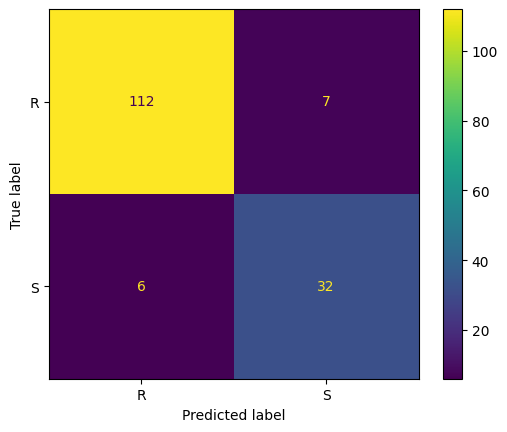

Results
Accuracy: 0.9171974522292994
R recall: 0.9411764705882353
S recall: 0.8421052631578947
R precision: 0.9491525423728814
S precision: 0.8205128205128205


In [16]:
Model_Report = evaluate(GB_AMP_GY_model, AMP_Train_test_dic['labels_test'],AMP_GY_labels_pred)

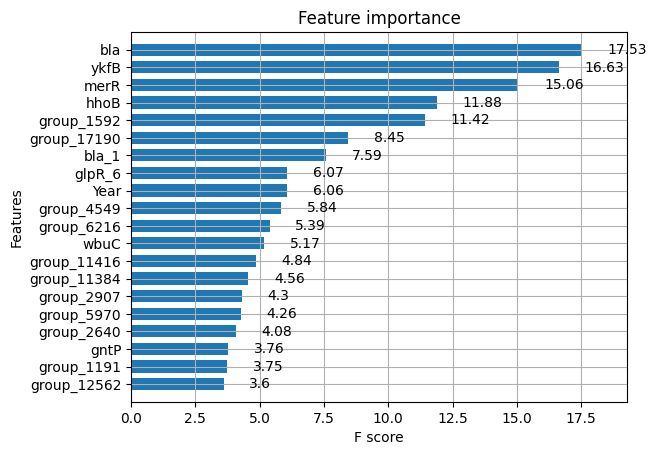

In [17]:
feat_imp = GB_AMP_GY_model.get_booster().get_score(importance_type="gain")
for k in feat_imp.keys():
    feat_imp[k] = round(feat_imp[k],2)

plot_importance(feat_imp, max_num_features = 20, importance_type = "gain", show_values=True, height=0.7)
plt.savefig('/content/drive/My Drive/EColi_ML_Plots/GB_AMP_GY_feat_importance.jpg',dpi=400, bbox_inches="tight")

In [18]:
hparam = {"eta":[0.1, 0.2, 0.4, 0.8]}

In [19]:
def GB_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  model = XGBClassifier(random_state = 42)
  scoring_dic = {'f1_macro':make_scorer(f1_score , average='macro')}
  feat = feat_train_df.drop(columns=["MLST"])
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})
  if str(cv).isnumeric():
    cv = KFold(cv)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t)
  elif cv == "blocked":
    groups= feat_train_df['MLST']
    cv = StratifiedGroupKFold(n_splits=4)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t, groups=groups)
  else:
    print("Please provide a valid crossvalidation scheme `blocked` or an integer")
  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

In [20]:
GB_tuned = GB_hp_tune(hparam, AMP_GY_train_df, AMP_Train_test_dic['labels_train'])

<ipython-input-19-3d138f4d263f>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....eta=0.1; f1_macro: (train=1.000, test=0.881) total time=  26.7s
[CV 2/4] END ....eta=0.1; f1_macro: (train=1.000, test=0.923) total time=  22.4s
[CV 3/4] END ....eta=0.1; f1_macro: (train=1.000, test=0.895) total time=  20.5s
[CV 4/4] END ....eta=0.1; f1_macro: (train=1.000, test=0.884) total time=  21.0s
[CV 1/4] END ....eta=0.2; f1_macro: (train=1.000, test=0.888) total time=  20.5s
[CV 2/4] END ....eta=0.2; f1_macro: (train=1.000, test=0.913) total time=  20.8s
[CV 3/4] END ....eta=0.2; f1_macro: (train=1.000, test=0.911) total time=  20.6s
[CV 4/4] END ....eta=0.2; f1_macro: (train=1.000, test=0.894) total time=  23.1s
[CV 1/4] END ....eta=0.4; f1_macro: (train=1.000, test=0.874) total time=  20.3s
[CV 2/4] END ....eta=0.4; f1_macro: (train=1.000, test=0.911) total time=  21.7s
[CV 3/4] END ....eta=0.4; f1_macro: (train=1.000, test=0.892) total time=  20.7s
[CV 4/4] END ....eta=0.4; f1_macro: (train=1.000,

In [21]:
drug_list = All_Drugs_df.iloc[:,3:15].columns
print(drug_list)

print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['Y', 'G', 'GY']


In [22]:
for fname in os.listdir(filepath):
    if fname.endswith('GB_metrics_df.csv'):
        print("A csv with stored results for XGBoost has already been created. Please check your Google Drive directory.")
        break
else:
  GB_model_metrics = {}

  for drug in drug_list:
    print(drug)
    Test_Train_dic = Split_train_test(drug)
    for combo in combo_list:
      labels_train = Test_Train_dic["labels_train"]
      features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)
      print(drug+"_"+combo)

      GB_combo_model = run_GB(features_train, labels_train, drug, combo)

      features_test = combo_feat(Test_Train_dic["features_test"], drug, combo)
      labels_pred = predict(GB_combo_model, features_test)
      labels_test = Test_Train_dic["labels_test"]
      report = evaluate(GB_combo_model, labels_test, labels_pred, cf=False, show_results=False)
      GB_model_metrics[drug+"_"+combo] = report
      print(report)

  GB_metrics = pd.DataFrame.from_dict(GB_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
  GB_metrics = GB_metrics.rename(columns = {'index':'Drug_combo'})

  GB_metrics.to_csv(filepath+"GB_metrics_df.csv", index= False)

CTZ
CTZ_Y
CTZ Training combo: Y
Number of Decicion Trees in XGB Classifier model: None
[0.8617021276595744, 0.038461538461538464, 0.9938271604938271, 0.5, 0.8655913978494624]
CTZ_G
CTZ Training combo: G
Number of Decicion Trees in XGB Classifier model: None
[0.9547872340425532, 0.75, 0.9876543209876543, 0.9069767441860465, 0.960960960960961]
CTZ_GY
CTZ Training combo: GY
Number of Decicion Trees in XGB Classifier model: None
[0.9627659574468085, 0.8076923076923077, 0.9876543209876543, 0.9130434782608695, 0.9696969696969697]
CTX
CTX_Y
CTX Training combo: Y
Number of Decicion Trees in XGB Classifier model: None
[0.8781163434903048, 0.42105263157894735, 1.0, 1.0, 0.8662613981762918]
CTX_G
CTX Training combo: G
Number of Decicion Trees in XGB Classifier model: None
[0.9750692520775623, 0.9342105263157895, 0.9859649122807017, 0.9466666666666667, 0.9825174825174825]
CTX_GY
CTX Training combo: GY
Number of Decicion Trees in XGB Classifier model: None
[0.9722991689750693, 0.9210526315789473, 0

A directory was already created to store your plot


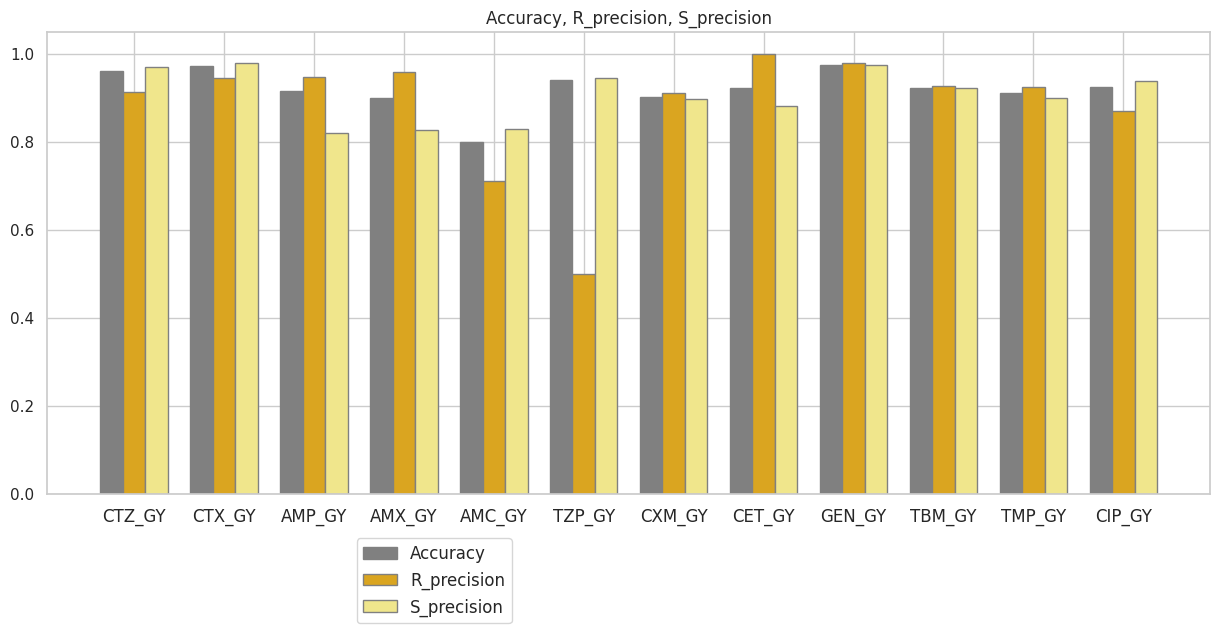

In [23]:
try:
  os.mkdir('/content/drive/My Drive/EColi_ML_Plots')
except:
  print("A directory was already created to store your plot")

GB_metrics = pd.read_csv("/content/drive/MyDrive/EColi_ML_CSV_files/GB_metrics_df.csv")
GY_filter = [drug_combo for drug_combo in GB_metrics['Drug_combo'] if drug_combo.endswith("GY")]
GY_df = GB_metrics.loc[GB_metrics["Drug_combo"].isin(GY_filter)]

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize =(15, 6))

plt.title('Accuracy, R_precision, S_precision', fontsize = 12)

x = np.arange(len(GY_df["Drug_combo"]))
acc = list(GY_df["Accuracy"])
R_prec = list(GY_df["R_precision"])
S_prec = list(GY_df["S_precision"])

acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="grey", edgecolor="gray")
rprec_bar=plt.bar(x, height= R_prec, width=0.25, color="goldenrod", edgecolor="gray")
sprec_bar=plt.bar(x+0.25, height= S_prec, width=0.25, color="khaki", edgecolor="gray")

plt.xticks([r for r in range(len(GY_df["Drug_combo"]))],
            GY_df["Drug_combo"], fontsize = 12)

fig.legend([acc_bar,rprec_bar,sprec_bar],["Accuracy", "R_precision", "S_precision"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

plt.savefig('/content/drive/My Drive/EColi_ML_Plots/GB_GY_Accuracy_and_Recall_Scores.jpg',dpi=400, bbox_inches="tight")

plt.show()